In [148]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [149]:
TEST_IMG_NAME = "pics2/test_image - 19.jpeg"

In [150]:
def display_scaled(pic, scale=1):
    h, w = pic.shape[:2]
    display(Image.fromarray(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)).resize((int(w * scale), int(h * scale)), Image.LANCZOS))

In [151]:
def show_gray_hist(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).ravel()
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.plot(hist)
    plt.xlim([0, 255])
    plt.show()

In [152]:
img_to_process_color = cv2.imread(TEST_IMG_NAME)
img_to_process_gray = cv2.cvtColor(img_to_process_color, cv2.COLOR_BGR2GRAY)

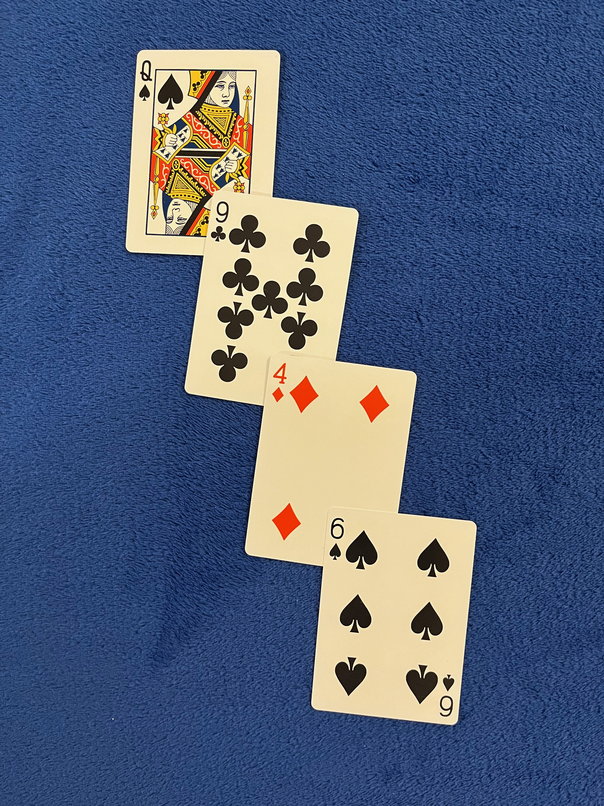

In [153]:
display_scaled(img_to_process_color, 0.2)

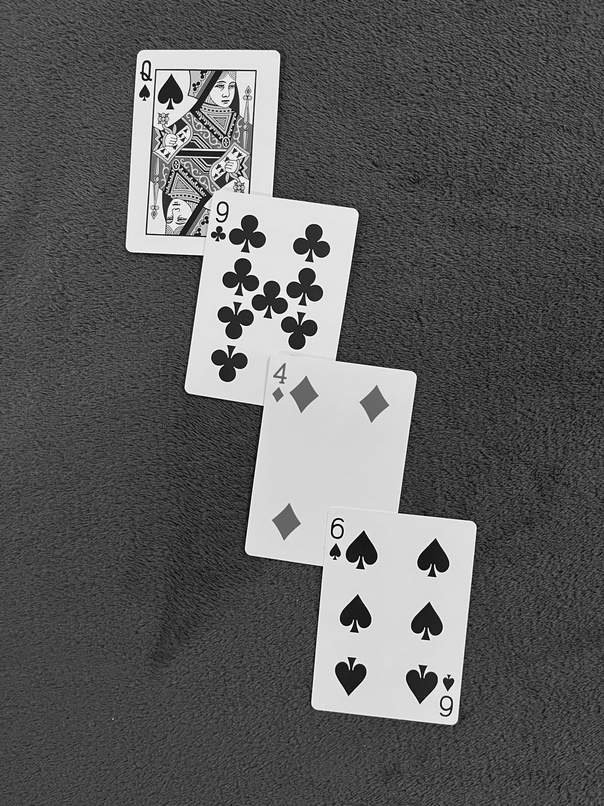

In [154]:
display_scaled(img_to_process_gray, 0.2)

In [155]:
_, img_to_process_thresh = cv2.threshold(img_to_process_gray, 150, 255, cv2.THRESH_BINARY)
img_to_process_masked = cv2.bitwise_and(img_to_process_gray, img_to_process_gray, mask=img_to_process_thresh)

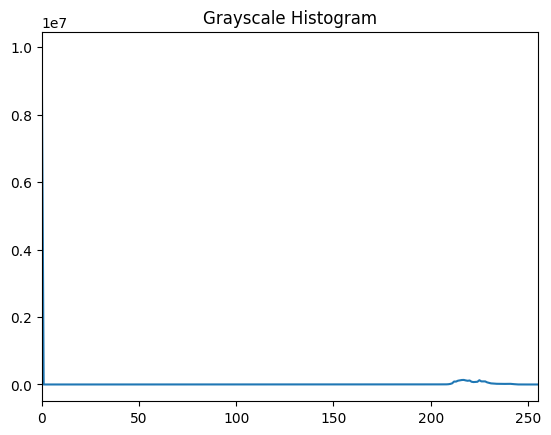

In [156]:
show_gray_hist(img_to_process_masked)

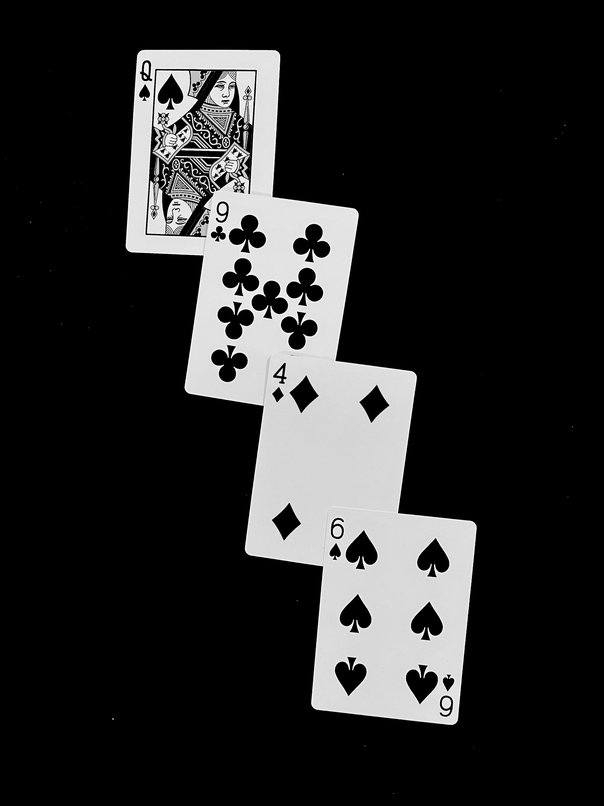

In [157]:
display_scaled(img_to_process_masked, 0.2)

In [158]:
sift = cv2.SIFT_create(
        contrastThreshold=0.01,
        edgeThreshold=12,
        nOctaveLayers=5,
        sigma=1.5)

In [159]:
kp, des = sift.detectAndCompute(img_to_process_masked, None)

In [160]:
len(kp)

15859

In [161]:
kp_img = cv2.drawKeypoints(img_to_process_color, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

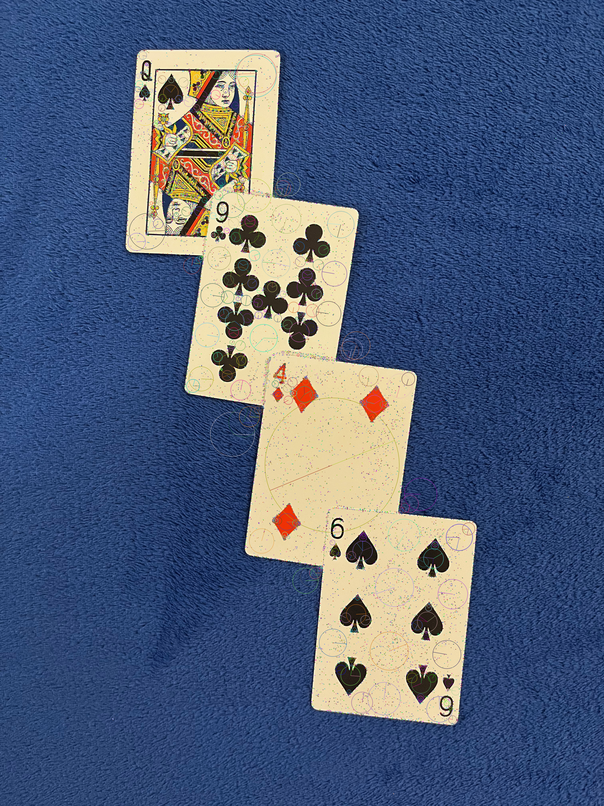

In [162]:
display_scaled(kp_img, 0.2)

In [163]:
REFERENCE_IMG_NAME = "references3/pikk_Q.warped.png"

In [164]:
card_to_search_color = cv2.imread(REFERENCE_IMG_NAME)
card_to_search_gray = cv2.cvtColor(card_to_search_color, cv2.COLOR_BGR2GRAY)
_, card_to_search_thresh = cv2.threshold(card_to_search_gray, 150, 255, cv2.THRESH_BINARY)
card_to_search_masked = cv2.bitwise_and(card_to_search_gray, card_to_search_gray, mask=card_to_search_thresh)

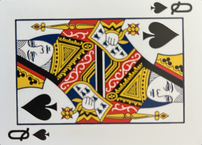

In [165]:
display_scaled(card_to_search_color, 0.25)

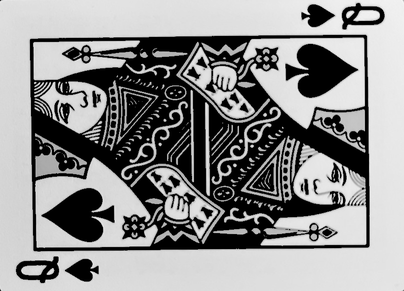

In [166]:
display_scaled(card_to_search_masked, 0.5)

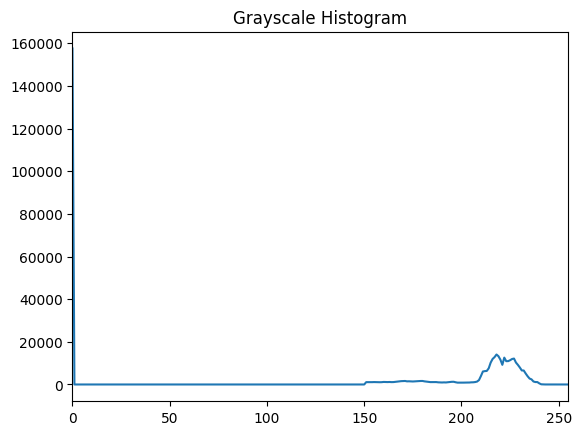

In [167]:
show_gray_hist(card_to_search_masked)

In [168]:
ref_kp, ref_des = sift.detectAndCompute(card_to_search_masked, None)

In [169]:
len(ref_kp)

3111

In [170]:
ref_kp_img = cv2.drawKeypoints(card_to_search_color, ref_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

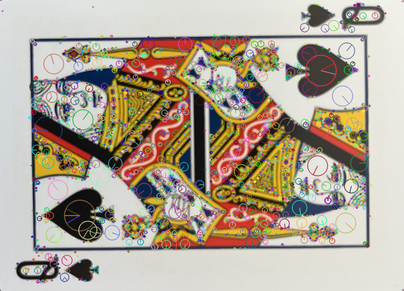

In [171]:
display_scaled(ref_kp_img, 0.5)

In [172]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

In [173]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [174]:
matches = bf.knnMatch(ref_des, des, k=2)

In [175]:
#matches = flann.knnMatch(ref_des, des, k=2)

In [176]:
DISTANCE_RATIO = 0.75

In [177]:
good_matches = [m for m, n in matches if m.distance < DISTANCE_RATIO * n.distance]

In [178]:
print(f"Found {len(good_matches)} good matches out of {len(matches)} total matches")

Found 383 good matches out of 3111 total matches


In [179]:
result_img = cv2.drawMatches(card_to_search_color, ref_kp, img_to_process_color, kp, good_matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

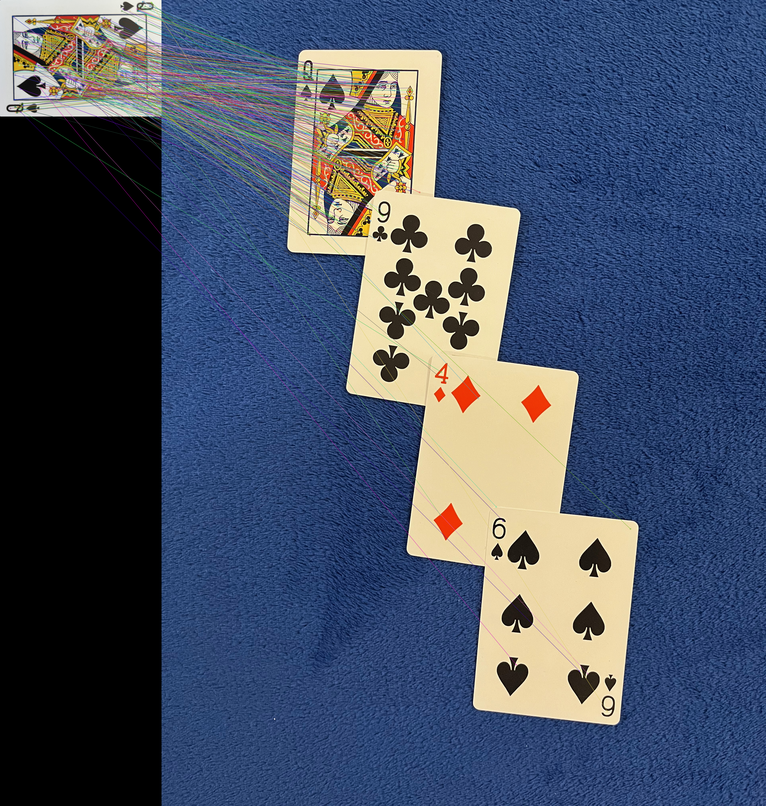

In [180]:
display_scaled(result_img, 0.2)

In [181]:
src_pts = np.float32([ref_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)

In [182]:
len(src_pts)

383

In [183]:
dst_pts = np.float32([kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

In [184]:
len(dst_pts)

383

In [185]:
src_pts.shape, dst_pts.shape

((383, 1, 2), (383, 1, 2))

In [186]:
#M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0, maxIters=50000, confidence=0.999)

In [187]:
#M, mask = cv2.findHomography(src_pts, dst_pts, cv2.USAC_ACCURATE, 5.0, maxIters=50000, confidence=0.999)

In [188]:
M, mask = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=3.0, maxIters=50000, confidence=0.999)
M = np.vstack([M, [0, 0, 1]])

In [189]:
matches_mask = mask.ravel().tolist()

In [190]:
np.sum(matches_mask)

np.int64(167)

In [191]:
h, w = card_to_search_color.shape[:2]
pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

In [192]:
dst = cv2.perspectiveTransform(pts, M)

In [193]:
result_img_annotated = img_to_process_color.copy()

In [194]:
result_img_annotated = cv2.polylines(result_img_annotated, [np.int32(dst)], True, (0, 255, 0), 10, cv2.LINE_AA)

In [195]:
print(f"Found matching card with {sum(matches_mask)} inliers out of {len(good_matches)} good matches")

Found matching card with 167 inliers out of 383 good matches


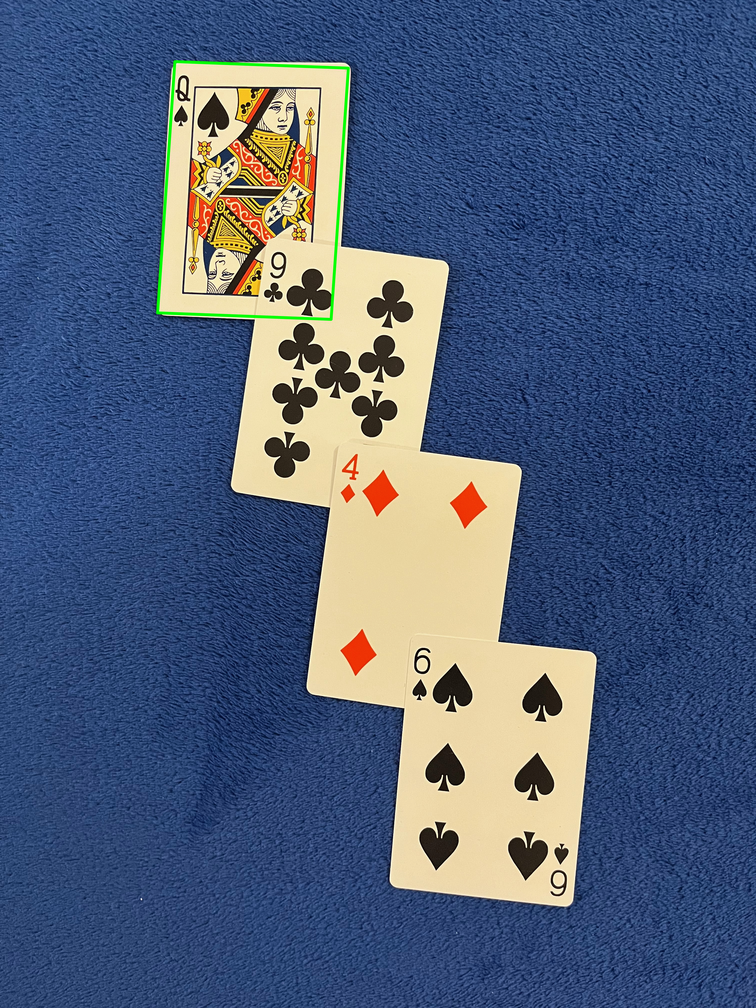

In [196]:
display_scaled(result_img_annotated, 0.25)